In [1]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","RColorBrewer","zoo","lubridate","tidyverse",
              "readxl","gridExtra","MASS","ggpubr", "mixdist")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

theme_set(theme_bw())
version$version.string

options(scipen=10000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ stringr 1.5.1
✔ purrr   1.0.2     ✔ tibble  3.2.1
✔ readr   2.1.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "R version 4.3.2 (2023-10-31)"

# Settings

In [2]:
readRDS("RDS/R0t_Delta.rds") -> result_Delta_MA
readRDS("RDS/R0t_Omicron.rds") -> result_Omicron_MA

In [3]:
## implementation time of major NPIs
NPI_0 <- as.Date("2021-11-01") ## announcing the gradual ease of the social distancing countermeasures
NPI_1 <- as.Date("2021-12-06") ## state of emergency
NPI_2 <- as.Date("2022-02-19") ## extending the restricted operation hour(21 -> 22)
NPI_3 <- as.Date("2022-03-05") ## extending the restricted operation hour (22 -> 23)
NPI_4 <- as.Date("2022-04-04") ## extending the restricted operation hour (23 -> 24)
NPI_5 <- as.Date("2022-04-18") ## lifting all interventions

## Moving average
MA=7

# Human mobility pattern

In [5]:
read.csv("../data/mobility_Seoul.csv") %>% filter(region==c("Seoul")) %>% 
mutate(date=as.Date(as.character(date),format = "%Y%m%d")) -> df_mobility
seq(min(df_mobility$date), max(df_mobility$date), 1) %>% as.data.frame() %>% rename(date='.') -> temp_cal
merge(temp_cal, df_mobility, by=c("date"), all.x=TRUE) %>% 
fill(region, week_radius, weekend_radius, week_distance, weekend_distance, .direction = "downup") -> df_mobility_daily

read.csv("../data/mobility_Seoul.csv") %>% filter(region==c("Gyeonggi")) %>% 
mutate(date=as.Date(as.character(date),format = "%Y%m%d")) -> df_mobility2
seq(min(df_mobility2$date), max(df_mobility2$date), 1) %>% as.data.frame() %>% rename(date='.') -> temp_cal
merge(temp_cal, df_mobility2, by=c("date"), all.x=TRUE) %>% 
fill(region, week_radius, weekend_radius, week_distance, weekend_distance, .direction = "downup") -> df_mobility_daily2

read.csv("../data/mobility_Seoul.csv") %>% filter(region==c("Incheon")) %>% 
mutate(date=as.Date(as.character(date),format = "%Y%m%d")) -> df_mobility3
seq(min(df_mobility3$date), max(df_mobility3$date), 1) %>% as.data.frame() %>% rename(date='.') -> temp_cal
merge(temp_cal, df_mobility3, by=c("date"), all.x=TRUE) %>% 
fill(region, week_radius, weekend_radius, week_distance, weekend_distance, .direction = "downup") -> df_mobility_daily3

In [6]:
pop <- c(9409466, 13624964, 2985152)

In [7]:
df_list <- list(
    df_mobility_daily %>% dplyr::select(date, region, week_distance, weekend_distance) %>% 
    rename(week_distance_Seoul=week_distance, weekend_distance_Seoul=weekend_distance),
    df_mobility_daily2 %>% dplyr::select(date, region, week_distance, weekend_distance) %>% 
    rename(week_distance_Gyeonggi=week_distance, weekend_distance_Gyeonggi=weekend_distance),
    df_mobility_daily3 %>% dplyr::select(date, region, week_distance, weekend_distance) %>% 
    rename(week_distance_Incheon=week_distance, weekend_distance_Incheon=weekend_distance))

Reduce(function(x, y) merge(x, y, by=c("date"), all=TRUE), df_list) %>%
mutate(week_distance=(week_distance_Seoul*pop[1]+week_distance_Gyeonggi*pop[2]+week_distance_Incheon*pop[3])/sum(pop),
       weekend_distance=(weekend_distance_Seoul*pop[1]+weekend_distance_Gyeonggi*pop[2]+weekend_distance_Incheon*pop[3])/sum(pop),) %>% 
dplyr::select(date, week_distance, weekend_distance) -> df_mobility_daily_metro

In [8]:
merge(result_Delta_MA %>% rename(date=onset), df_mobility_daily %>% dplyr::select(-region), 
                                   by=c("date"), all.x=TRUE) -> df_Rt_mobility

merge(result_Omicron_MA %>% rename(date=onset), df_mobility_daily %>% dplyr::select(-region), 
                                   by=c("date"), all.x=TRUE) -> df_Rt_mobility2

merge(result_Delta_MA %>% rename(date=onset), df_mobility_daily_metro, by=c("date"), all.x=TRUE) -> df_Rt_mobility_2

merge(result_Omicron_MA %>% rename(date=onset), df_mobility_daily_metro, by=c("date"), all.x=TRUE) -> df_Rt_mobility2_2

In [14]:
df_mobility_daily_metro %>% filter() %>% gather(group, value, -date) -> mobility_figure2

#### adding social distancing level (adjusted to the equivalent level as interventions in 2022)
mobility_figure2 %<>% 
mutate(level=case_when(date < as.Date("2020-06-28") ~ 2,
                       date >= as.Date("2020-06-28") & date < as.Date("2020-11-07") ~ 4,
                       date >= as.Date("2020-11-07") & date < as.Date("2021-03-05") ~ 3,
                       date >= as.Date("2021-03-05") & date < as.Date("2021-07-09") ~ 2,
                       date >= as.Date("2021-07-09") & date < as.Date("2021-11-01") ~ 4,
                       date >= as.Date("2021-11-01") & date < as.Date("2021-12-06") ~ 2,
                       date >= as.Date("2021-12-06") & date < as.Date("2022-02-19") ~ 4,
                       date >= as.Date("2022-02-19") & date < as.Date("2022-03-05") ~ 3,
                       date >= as.Date("2022-03-05") & date < as.Date("2022-04-04") ~ 2,
                       date >= as.Date("2022-04-04") & date < as.Date("2022-04-18") ~ 1,
                       date >= as.Date("2022-04-18") ~ 0))

scaling_parameter=max(mobility_figure2$value)/max(df_Rt_mobility$MA_Rt)
adj=0.735

options(repr.plot.width=10,repr.plot.height=6)
df_Rt_mobility %>% filter(date >= as.Date("2021-08-16")) %>%
    ggplot() + 
    geom_line(data= df_Rt_mobility %>% filter(date >= as.Date("2021-08-16")),
              aes(x=date, y=MA_Rt*scaling_parameter*adj),color="#1380A1",size=1) +
    geom_ribbon(aes(x=date, ymax=MA_upper*scaling_parameter*adj, ymin=MA_lower*scaling_parameter*adj), 
                fill="#1380A1", alpha = 0.4) +
    geom_step(mobility_figure2 %>% filter(date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")), 
              mapping=aes(x=date,y=level*scaling_parameter*adj), color="#990000", linetype='longdash', size=1) +
    geom_line(data=mobility_figure2 %>% filter(group==c("week_distance") & 
                                               date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")), 
              aes(x=date, y=value), color="#FAAB18", size=1.3) +
#     geom_line(data=mobility_figure2 %>% filter(group==c("weekend_distance") & 
#                                                date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")), 
#               aes(x=date, y=value), linetype='dotted', color="#FAAB18", size=1.3) +
    ggtitle("Comparison with human mobility pattern (Delta period)") +
    labs(x="\n Date of infection", y="Weekday average movement distance (km)\n") +
    theme(text = element_text(size=17, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 17),
          legend.text = element_text(size = 17),
          plot.title = element_text(size=18, family="sans",color="black")) +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0),
                       sec.axis = sec_axis(~./(scaling_parameter*adj), breaks=c(0,1,2,3,4,5),  
                                           name = "")) +
    coord_cartesian(ylim = c(0,20000)) +
    annotate("rect", xmin = as.Date("2021-09-20"), xmax = as.Date("2021-09-22"), 
             ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") -> Delta_period
#     annotate("rect", xmin = as.Date("2021-09-18"), xmax = as.Date("2021-09-26"), 
#              ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
#     annotate("rect", xmin = as.Date("2021-10-03"), xmax = as.Date("2021-10-04"), 
#              ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
#     annotate("rect", xmin = as.Date("2021-10-09"), xmax = as.Date("2021-10-10"), 
#              ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
#     annotate("rect", xmin = as.Date("2021-12-25"), xmax = as.Date("2021-12-26"), 
#              ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") -> Delta_period
                 
adj2=0.735

as.data.frame(c("Mobility", "Intervention", "R_0t")) -> temp; colnames(temp) <- c("Group")
temp %<>% mutate(date=as.Date("2022-03-01"), value= -5)
                 
df_Rt_mobility2 %>% filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")) %>%
    ggplot() + 
    geom_line(aes(x=date, y=MA_Rt*scaling_parameter*adj2),color="#1380A1",size=1) +
    geom_ribbon(aes(x=date, ymax=MA_upper*scaling_parameter*adj2, ymin=MA_lower*scaling_parameter*adj2), 
                fill="#1380A1", alpha = 0.4) +
    geom_step(data=mobility_figure2 %>% filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")),
              mapping=aes(x=date,y=level*scaling_parameter*adj2), color="#990000", linetype='longdash', size=1) +
    geom_line(data=temp, aes(x=date, y=value, color=Group)) +
    geom_line(data=mobility_figure2 %>% filter(group==c("week_distance") & 
                                               date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")),
              aes(x=date, y=value), color="#FAAB18", size=1.3) +
#     geom_line(data=mobility_figure2 %>% filter(group==c("weekend_distance") & 
#                                                date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")),
#               aes(x=date, y=value), linetype='dotted', color="#FAAB18", size=1.3) +
    scale_color_manual("", values = c("#990000", "#FAAB18", "#1380A1")) +
    ggtitle("Comparison with human mobility pattern (Omicron period)") +
    labs(x="\n Date of infection", y="") +
    theme(text = element_text(size=17, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 17),
          legend.text = element_text(size = 17),
          legend.position = c(0.85, 0.87), legend.margin=unit(-1,"cm"), legend.key.width = unit(1,"cm"),
          plot.title = element_text(size=18, family="sans",color="black")) +
    guides(color = guide_legend(override.aes = list(linewidth = 1.5)))+
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0), sec.axis = sec_axis(~./(scaling_parameter*adj2), breaks=c(0,1,2,3,4,5),  
    name = "Level of social distancing measures / \n Time-varying basic reproduction number \n")) +
    coord_cartesian(ylim = c(0,20000)) +
    annotate("rect", xmin = as.Date("2022-01-31"), xmax = as.Date("2022-02-02"), 
             ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
#     annotate("rect", xmin = as.Date("2022-01-29"), xmax = as.Date("2022-02-06"), 
#              ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
    annotate("rect", xmin = as.Date("2022-03-01"), xmax = as.Date("2022-03-02"), 
             ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") +
    annotate("rect", xmin = as.Date("2022-03-09"), xmax = as.Date("2022-03-10"), 
             ymin = 0, ymax = 20000, alpha = 0.2, fill = "indianred2") -> Omicron_period

In [10]:
readRDS("result_non_Omi_smooth.rds") -> result_non_Omi
readRDS("result_Omi_smooth.rds") -> result_Omi

merge(result_non_Omi %>% rename(date=onset) %>% filter(date >= as.Date("2021-08-16") & date <= as.Date("2022-12-31")),
      mobility_figure2 %>% filter(group==c("week_distance")), by=c("date"), all.x=TRUE) %>%
filter(date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")) %>%
filter(!(date >= as.Date("2021-09-20") & date <= as.Date("2021-09-26"))) -> temp1

merge(result_Omi %>% rename(date=onset) %>% filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")), 
      mobility_figure2 %>% filter(group==c("week_distance")), by=c("date"), all.x=TRUE) %>%
filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")) %>%
filter(!(date >= as.Date("2022-01-29") & date <= as.Date("2022-02-06"))) -> temp2

cor.test(temp1$MA_Rt, temp1$value, method = "pearson")
cor.test(temp2$MA_Rt, temp2$value, method = "pearson")

merge(df_Rt_mobility, mobility_figure2 %>% filter(group==c("week_distance")), by=c("date"), all.x=TRUE) %>%
filter(date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")) %>%
filter(!(date >= as.Date("2021-09-20") & date <= as.Date("2021-09-26"))) -> temp1

merge(df_Rt_mobility2, mobility_figure2 %>% filter(group==c("week_distance")), by=c("date"), all.x=TRUE) %>%
filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")) %>%
filter(!(date >= as.Date("2022-01-29") & date <= as.Date("2022-02-06"))) -> temp2

cor.test(temp1$MA_Rt, temp1$value, method = "pearson")
cor.test(temp2$MA_Rt, temp2$value, method = "pearson")


	Pearson's product-moment correlation

data:  temp1$MA_Rt and temp1$value
t = 4.9637, df = 129, p-value = 0.000002144
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2458166 0.5352193
sample estimates:
      cor 
0.4004573 



	Pearson's product-moment correlation

data:  temp2$MA_Rt and temp2$value
t = -2.6389, df = 96, p-value = 0.009706
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.43598831 -0.06499892
sample estimates:
       cor 
-0.2600656 



	Pearson's product-moment correlation

data:  temp1$MA_Rt and temp1$value
t = 6.7351, df = 129, p-value = 0.0000000004883
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3709872 0.6267487
sample estimates:
      cor 
0.5100559 



	Pearson's product-moment correlation

data:  temp2$MA_Rt and temp2$value
t = 2.3209, df = 96, p-value = 0.02241
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.03361535 0.41016048
sample estimates:
      cor 
0.2304987 


In [13]:
options(repr.plot.width=6,repr.plot.height=6)
df_Rt_mobility_2 %>% filter(date >= as.Date("2021-08-16") & date <= as.Date("2021-12-31")) %>%
filter(!(date >= as.Date("2021-09-20") & date <= as.Date("2021-09-26"))) %>%
ggplot(aes(x = week_distance , y = MA_Rt)) + 
geom_point(size=2) + geom_smooth(method=lm, color="lightslateblue", fill="lightslateblue") +
scale_y_continuous(limits=c(1.5, 4))+
scale_x_continuous(limits=c(9000, 12500))+
theme(legend.position="none",
      text = element_text(size=17, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black")) +
ggtitle("Correlation with human mobility pattern (Delta period)") +
labs(x="\n Weekday average movement distance (km)", y="Time-varying basic reproduction number \n") -> corr

options(repr.plot.width=6,repr.plot.height=6)
df_Rt_mobility2_2 %>% filter(date >= as.Date("2022-01-15") & date <= as.Date("2022-05-01")) %>%
filter(!(date >= as.Date("2022-01-29") & date <= as.Date("2022-02-06"))) %>%
ggplot(aes(x = week_distance, y = MA_Rt)) + 
geom_point(size=2) + geom_smooth(method=lm, color="lightslateblue", fill="lightslateblue") +
scale_y_continuous(limits=c(2, 3.5))+
scale_x_continuous(limits=c(8000, 12000))+
theme(legend.position="none",
      text = element_text(size=17, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black")) +
ggtitle("Correlation with human mobility pattern (Omicron period)") +
labs(x="\n Weekday average movement distance (km)", y="") -> corr2

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


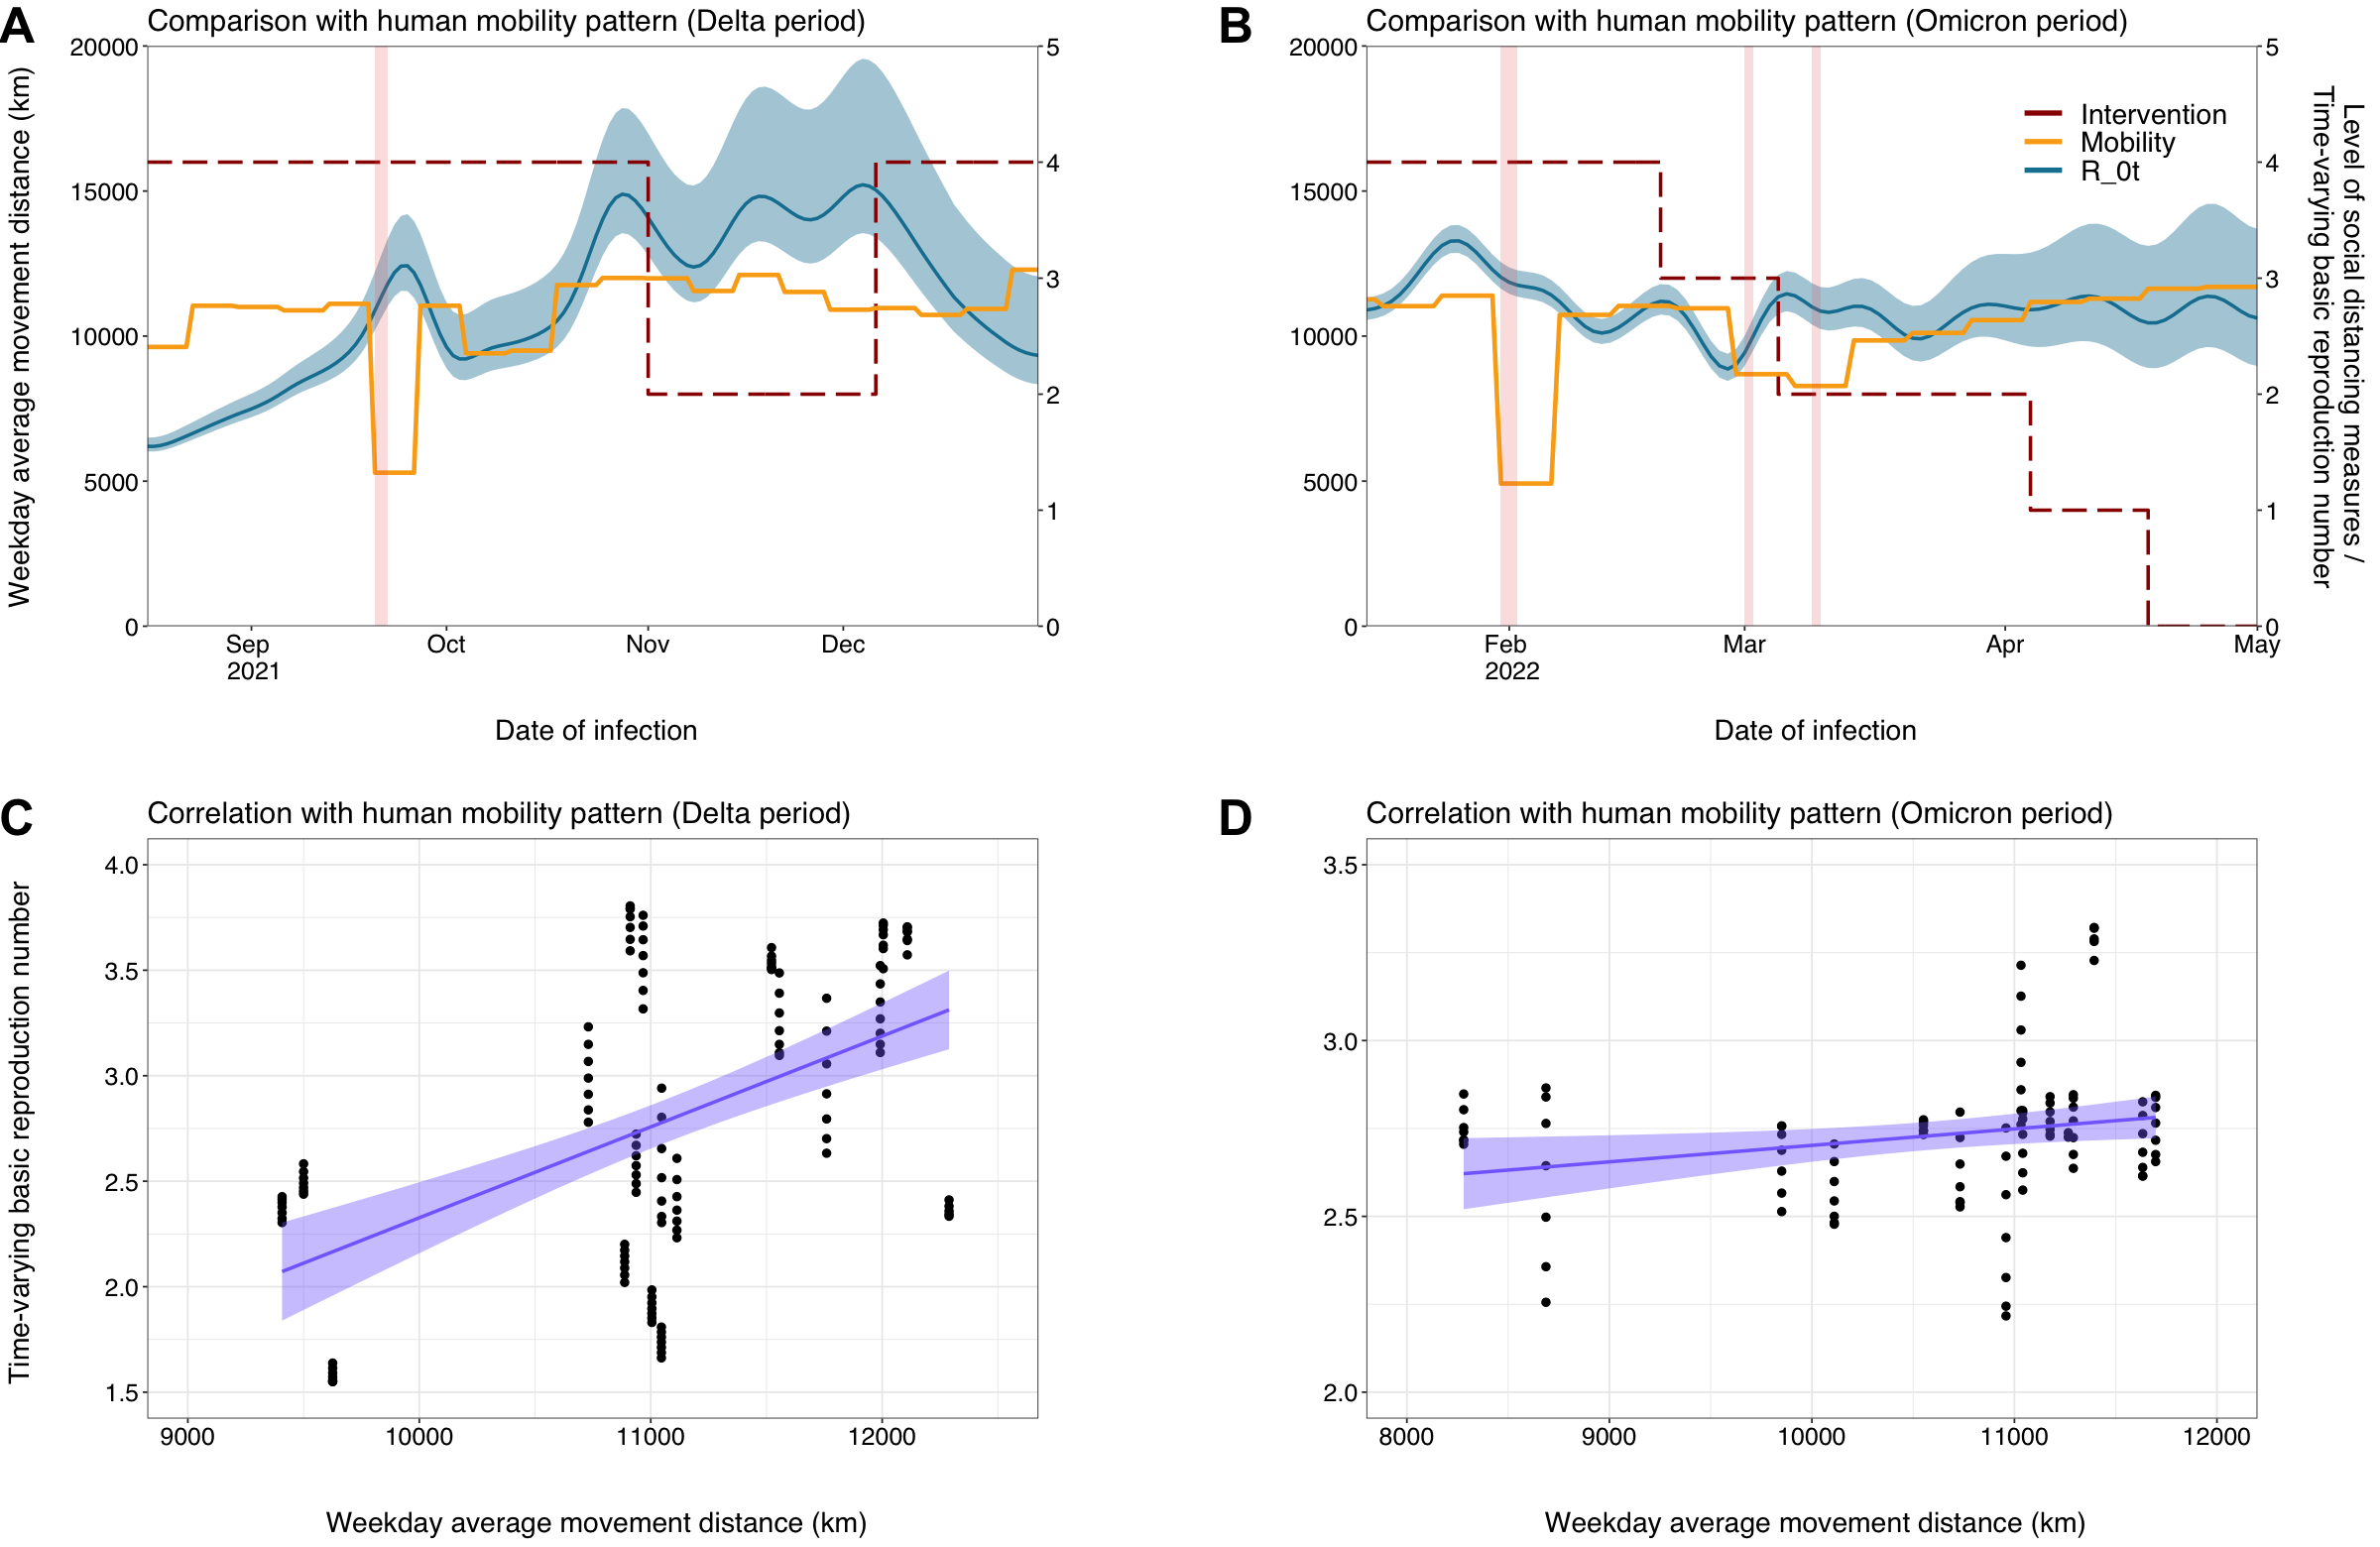

In [12]:
options(repr.plot.width=20,repr.plot.height=13)
ggarrange(Delta_period, ggplot() + theme_void(), Omicron_period,
          ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(), 
          corr, ggplot() + theme_void(), corr2,           
          ncol=3, nrow=3, widths = c(1, 0.05, 1), heights = c(1, 0.05, 1), align = "hv",
          labels = c("A", "", "B", "", "", "", "C", "", "D"), font.label = list(size = 30), vjust=1.2, hjust=0.02)

ggsave("../figures/Final figures/Fig_3.png", width = 20, height = 13, dpi=300, bg="white")